# benchmark peak-calling methods

- Last updated: 6/10/2023
- Author: Yang-Joon Kim

**DESCRIPTION**

- We used MACS2 (implemented in Signac) to call peaks at different group.by resolutions
- First, we have Cellranger-arc called peaks ("ATAC" assay)
- Second, we call peaks for the bulk dataset using MACS2 ("peaks_bulk" assay)
- Third, we call peaks for each cell-type (coarse-grained, and predicted cell-type labels based on RNA - "peaks_celltype" assay)
- Lastly, we used the "iterative overlap peak-merging" approach inspired by ArchR tutorial (https://www.archrproject.com/bookdown/the-iterative-overlap-peak-merging-procedure.html). Briefly, we take the cell-type specific peaks as the most important peaks, then iteratively add overlapping peaks from MACS2-bulk peaks, and then CRG-arc peaks.


## Goals
- [peaks_1 vs peaks_2] for a Seurat object, generate descriptive plots for how much different peak profiles overlap, etc.
- [biological replicates] for two Seurat objects, show how much overlap is present between the two objects (between replicates and non-replicates).

In [2]:
suppressMessages(library(Signac))
suppressMessages(library(Seurat))
suppressMessages(library(GenomeInfoDb))

library(ggplot2)
library(dplyr)
library(RColorBrewer)
library(patchwork)
library(stringr)
library(VennDiagram)
library(GenomicRanges)

# zebrafish genome
library(BSgenome.Drerio.UCSC.danRer11)


Attaching package: ‘dplyr’


The following object is masked from ‘package:GenomeInfoDb’:

    intersect


The following objects are masked from ‘package:IRanges’:

    collapse, desc, intersect, setdiff, slice, union


The following objects are masked from ‘package:S4Vectors’:

    first, intersect, rename, setdiff, setequal, union


The following objects are masked from ‘package:BiocGenerics’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: BSgenome

Loading required package: Biostrings

Loading required package: XVector


Attaching package: ‘Biostrings’


The following object is masked from ‘package:base’:

    strsplit


Loading required package: rtracklayer



## Import the datasets

### replicates
- TDR118 (15-somites)
- TDR119 (15-somites, biological replicate)

### non-replicates
- TDR126 (0-somite, budstage)
- TDR124 (30-somites)

In [3]:
# data path
data_path = "/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/01_Signac_processed/"

# TDR118 (15-somites)
TDR118 <- readRDS(paste0(data_path, "TDR118reseq/TDR118_processed.RDS"))

# TDR119 (15-somites)
TDR119 <- readRDS(paste0(data_path, "TDR119reseq/TDR119_processed.RDS"))

# TDR126 (0 budstage)
TDR126 <- readRDS(paste0(data_path, "TDR126/TDR126_processed.RDS"))

# TDR124 (30-somites)
TDR124 <- readRDS(paste0(data_path, "TDR124reseq/TDR124_processed.RDS"))
TDR124

An object of class Seurat 
1478015 features across 6610 samples within 7 assays 
Active assay: peaks_merged (494511 features, 492495 variable features)
 6 other assays present: RNA, ATAC, SCT, peaks_bulk, peaks_celltype, Gene.Activity
 5 dimensional reductions calculated: pca, umap.rna, lsi, umap.atac, umap.joint

In [4]:
# List of assays to keep
assaysToKeep <- c("peaks_merged", "RNA", "SCT")

# Function to remove other assays from a Seurat object
remove_unwanted_assays <- function(seuratObject, assaysToKeep) {
  allAssays <- names(seuratObject@assays)
  assaysToRemove <- setdiff(allAssays, assaysToKeep)
  
  for (assay in assaysToRemove) {
    seuratObject[[assay]] <- NULL
  }
  
  return(seuratObject)
}

# Apply the function to each of your Seurat objects
# TDR118 <- remove_unwanted_assays(TDR118, assaysToKeep)
TDR119 <- remove_unwanted_assays(TDR119, assaysToKeep)
TDR124 <- remove_unwanted_assays(TDR124, assaysToKeep)
TDR126 <- remove_unwanted_assays(TDR126, assaysToKeep)

In [5]:
# define the path to save the plots
figpath = "/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/zebrahub-multiome-analysis/figures/peak_calling_benchmark/"


## Step 1. Check the peak profiles called by different methods

- 1) check the number of peaks for each method
- 2) check the coverage of peak profiles for each method (% genome?)
- 3) [HOLD] check the "reduce" method for joining peaks, and compare the joint peak profiles with the other methods by using "CoveragePlot" for some marker genes.


In [4]:
# 1) check the number of peaks for each method
TDR118@assays$ATAC@ranges

GRanges object with 248320 ranges and 0 metadata columns:
           seqnames            ranges strand
              <Rle>         <IRanges>  <Rle>
       [1]        1         2372-3057      *
       [2]        1         6507-7253      *
       [3]        1       11485-12198      *
       [4]        1       14475-15248      *
       [5]        1       16516-17393      *
       ...      ...               ...    ...
  [248316]        9 56433462-56434391      *
  [248317]        9 56437053-56437849      *
  [248318]        9 56450898-56451686      *
  [248319]        9 56452315-56452858      *
  [248320]        9 56459068-56459827      *
  -------
  seqinfo: 25 sequences from an unspecified genome; no seqlengths

In [5]:
# check the number of peaks for each method
TDR118@assays$peaks_bulk@ranges

GRanges object with 435704 ranges and 0 metadata columns:
           seqnames            ranges strand
              <Rle>         <IRanges>  <Rle>
       [1]        1         3596-4069      *
       [2]        1         4478-6981      *
       [3]        1       11049-12897      *
       [4]        1       14695-15041      *
       [5]        1       18522-19033      *
       ...      ...               ...    ...
  [435700]        9 56455828-56456125      *
  [435701]        9 56457205-56457539      *
  [435702]        9 56459130-56459697      *
  [435703]       MT           29-3505      *
  [435704]       MT       13232-16545      *
  -------
  seqinfo: 26 sequences from an unspecified genome; no seqlengths

In [6]:
# generate dataframes for each peak profiles (CRG-arc, MACS2-bulk, and MACS2-celltype)
df_CRG_peaks = as.data.frame(TDR118@assays$ATAC@ranges)
head(df_CRG_peaks)

df_MACS2_bulk_peaks = as.data.frame(TDR118@assays$peaks_bulk@ranges)
head(df_MACS2_bulk_peaks)

df_MACS2_celltype_peaks = as.data.frame(TDR118@assays$peaks_celltype@ranges)
head(df_MACS2_celltype_peaks)

,seqnames,start,end,width,strand
,<fct>,<int>,<int>,<int>,<fct>
1,1,2372,3057,686,*
2,1,6507,7253,747,*
3,1,11485,12198,714,*
4,1,14475,15248,774,*
5,1,16516,17393,878,*
6,1,17575,18198,624,*


,seqnames,start,end,width,strand
,<fct>,<int>,<int>,<int>,<fct>
1,1,3596,4069,474,*
2,1,4478,6981,2504,*
3,1,11049,12897,1849,*
4,1,14695,15041,347,*
5,1,18522,19033,512,*
6,1,19253,19614,362,*


,seqnames,start,end,width,strand
,<fct>,<int>,<int>,<int>,<fct>
1,1,3427,4032,606,*
2,1,4473,6136,1664,*
3,1,11020,12944,1925,*
4,1,13368,13575,208,*
5,1,14640,15050,411,*
6,1,16769,17193,425,*


In [21]:
# filter out the peaks from the "MT" chromosome as Cellranger-arc did not call the peaks from the "MT" chromosomes,
# so it'd be a fair comparison if we exlude the peaks from the "MT" chromosome for the MACS2-called peaks.

# # Filter out rows where seqnames is "MT"
# df_MACS2_bulk_peaks <- df_MACS2_bulk_peaks %>% filter(seqnames != "MT")
# df_MACS2_celltype_peaks <- df_MACS2_celltype_peaks %>% filter(seqnames != "MT")

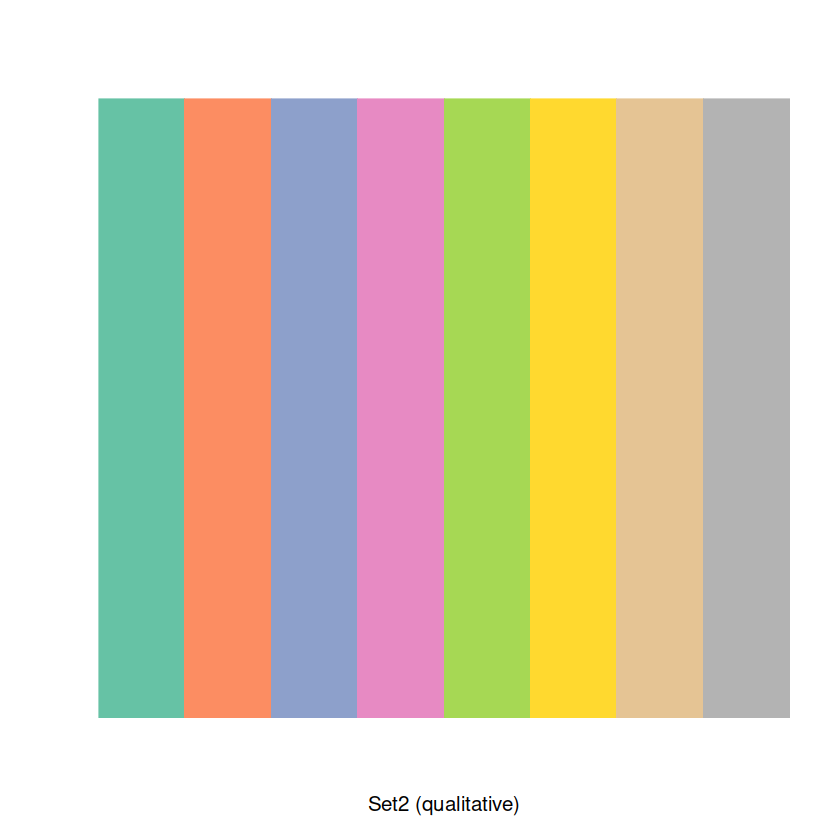

In [20]:
display.brewer.pal(n = 8, name = 'Set2')

# Get the colors from Set3 paletteb
colors <- brewer.pal(n = 8, name = "Set2")

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
Warning message:
“The `size` argument of `element_rect()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”
Warning message:
“The dot-dot notation (`..density..`) was deprecated in ggplot2 3.4.0.
ℹ Please use `after_stat(density)` instead.”
Warning message:
“Removed 11930 rows containing non-finite values (`stat_bin()`).”
Warning message:
“Removed 11930 rows containing non-finite values (`stat_density()`).”
Warning message:
“Removed 6 rows containing missing values (`geom_bar()`).”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 11930 rows containing non-finite values (`stat_bin()`).”
Warning message:
“Removed 11930 rows containing non-finite values (`stat_density()`).”
Warning message:
“Removed 6 rows containing missing values (`geom_bar()`).”
Saving 6.67 x 6.67 in image
Warning message:
“Removed 11930 rows containing non-finite 

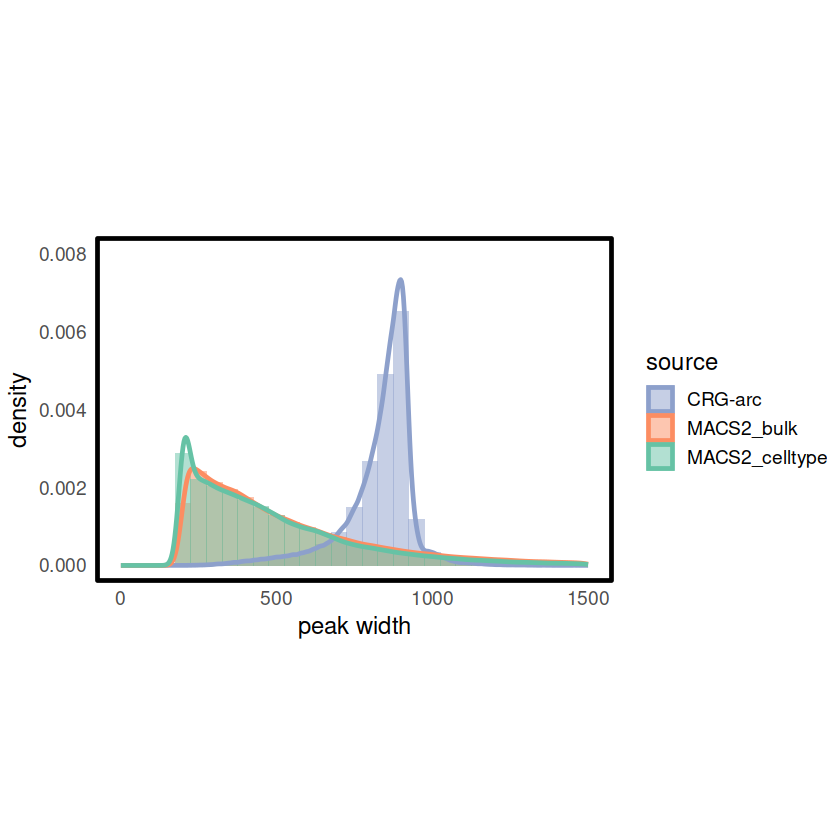

In [22]:
# Combine dataframes
df_CRG_peaks$source <- 'CRG-arc'
df_MACS2_bulk_peaks$source <- 'MACS2_bulk'
df_MACS2_celltype_peaks$source <- 'MACS2_celltype'

combined_df <- bind_rows(df_CRG_peaks %>% select(width, source),
                         df_MACS2_bulk_peaks %>% select(width, source),
                         df_MACS2_celltype_peaks %>% select(width, source)) %>%
  filter(is.finite(width) & !is.na(width))

# Use colors from Set3 palette
colors <- brewer.pal(n = 8, name = "Set2")
selected_colors <- c(colors[3], colors[2], colors[1])

# # Function to normalize counts
# normalize_counts <- function(df) {
#   df %>%
#     group_by(source) %>%
#     mutate(norm_density = ..count.. / sum(..count..)) %>%
#     ungroup()
# }

# # Plot the combined normalized density histogram
# plot <- ggplot(combined_df, aes(x = width, fill = source)) +
#   # geom_histogram(aes(y = ..count../sum(..count..)), position = "identity", alpha = 0.5, binwidth = 50) +
#         geom_histogram(aes(y = ..density..), stat = "density", position = "identity", alpha = 0.5, binwidth = 50) +
#         labs(title = "",
#         x = "peak width",
#         y = "frequency") +
#         theme_minimal(base_size = 14) +
#         scale_fill_manual(values = selected_colors) + # Adjust the indices to select desired colors
#         theme(
#         panel.grid.major = element_blank(), 
#         panel.grid.minor = element_blank(),
#         text = element_text(size = 14)
#         ) +
#       xlim(0, 1500)
# Plot the combined density histogram with KDE lines
plot <- ggplot(combined_df, aes(x = width, fill = source)) +
  geom_histogram(aes(y = ..density..), position = "identity", alpha = 0.5, binwidth = 50) +
  geom_density(aes(color = source), size = 1, fill=NA) +
  labs(title = "",
       x = "peak width",
       y = "density") +
  theme_minimal(base_size = 14) +
  scale_fill_manual(values = selected_colors) + # Adjust the indices to select desired colors
  scale_color_manual(values = selected_colors) + # Use the same colors for the KDE lines
  theme(
    panel.grid.major = element_blank(), 
    panel.grid.minor = element_blank(),
    text = element_text(size = 14),
    aspect.ratio = 1/1.5, # Adjust the aspect ratio to squeeze the y-axis
    panel.border = element_rect(color = "black", fill = NA, size = 1), # Add a black border around the plot
    plot.margin = margin(t = 5, r = 5, b = 5, l = 5, unit = "pt") 
  ) + coord_cartesian(clip = "off") +  # Ensure the plot area extends to the edges
  xlim(0, 1500) + ylim(0, 0.008)

plot

# define the figure path
path_name <- paste0(figpath, "hist_peak_widths_TDR118.svg")
ggsave(path_name, plot, device = "svg")

path_name <- paste0(figpath, "hist_peak_widths_TDR118.pdf")
ggsave(path_name, plot, device = "pdf")

In [16]:
# # export these dataframes to "csv" files for pandas data wrangling using python.
# write.csv(df_CRG_peaks, file="/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/TDR118_cicero_output/df_CRG_peaks.csv")
# write.csv(df_MACS2_bulk_peaks, file="/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/TDR118_cicero_output/df_MACS2_bulk_peaks.csv")
# write.csv(df_MACS2_celltype_peaks, file="/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/TDR118_cicero_output/df_MACS2_celltype_peaks.csv")


### Compute the overlap between peak profiles

In [23]:
# create gRanges objects from the dataframes (or we can just grab the gRanges objects from the Seurat objects)
gr_celltype <- GRanges(seqnames = df_MACS2_celltype_peaks$seqnames,
                       ranges = IRanges(start = df_MACS2_celltype_peaks$start, 
                                        end = df_MACS2_celltype_peaks$end))

gr_bulk <- GRanges(seqnames = df_MACS2_bulk_peaks$seqnames,
                   ranges = IRanges(start = df_MACS2_bulk_peaks$start, 
                                    end = df_MACS2_bulk_peaks$end))

gr_CRG_arc <- GRanges(seqnames = df_CRG_peaks$seqnames,
                      ranges = IRanges(start = df_CRG_peaks$start, 
                                       end = df_CRG_peaks$end))


In [32]:
gr_celltype

gr_bulk

gr_CRG_arc

GRanges object with 321849 ranges and 0 metadata columns:
           seqnames            ranges strand
              <Rle>         <IRanges>  <Rle>
       [1]        1         3427-4032      *
       [2]        1         4473-6136      *
       [3]        1       11020-12944      *
       [4]        1       13368-13575      *
       [5]        1       14640-15050      *
       ...      ...               ...    ...
  [321845]       25 37488393-37488764      *
  [321846]       25 37488899-37489203      *
  [321847]       25 37489634-37490735      *
  [321848]       25 37498173-37500021      *
  [321849]       25 37501104-37501804      *
  -------
  seqinfo: 26 sequences from an unspecified genome; no seqlengths

GRanges object with 435702 ranges and 0 metadata columns:
           seqnames            ranges strand
              <Rle>         <IRanges>  <Rle>
       [1]        1         3596-4069      *
       [2]        1         4478-6981      *
       [3]        1       11049-12897      *
       [4]        1       14695-15041      *
       [5]        1       18522-19033      *
       ...      ...               ...    ...
  [435698]        9 56453745-56454385      *
  [435699]        9 56455070-56455369      *
  [435700]        9 56455828-56456125      *
  [435701]        9 56457205-56457539      *
  [435702]        9 56459130-56459697      *
  -------
  seqinfo: 26 sequences from an unspecified genome; no seqlengths

GRanges object with 248320 ranges and 0 metadata columns:
           seqnames            ranges strand
              <Rle>         <IRanges>  <Rle>
       [1]        1         2372-3057      *
       [2]        1         6507-7253      *
       [3]        1       11485-12198      *
       [4]        1       14475-15248      *
       [5]        1       16516-17393      *
       ...      ...               ...    ...
  [248316]        9 56433462-56434391      *
  [248317]        9 56437053-56437849      *
  [248318]        9 56450898-56451686      *
  [248319]        9 56452315-56452858      *
  [248320]        9 56459068-56459827      *
  -------
  seqinfo: 25 sequences from an unspecified genome; no seqlengths

In [33]:
# Finding overlaps
overlap_celltype_bulk <- findOverlaps(gr_celltype, gr_bulk)
overlap_celltype_CRG_arc <- findOverlaps(gr_celltype, gr_CRG_arc)
overlap_bulk_CRG_arc <- findOverlaps(gr_bulk, gr_CRG_arc)

# You can also intersect the ranges
intersect_celltype_bulk <- intersect(gr_celltype, gr_bulk)


In [34]:
overlap_celltype_bulk

Hits object with 299754 hits and 0 metadata columns:
           queryHits subjectHits
           <integer>   <integer>
       [1]         1           1
       [2]         2           2
       [3]         3           3
       [4]         5           4
       [5]         8           5
       ...       ...         ...
  [299750]    321847      297122
  [299751]    321847      297123
  [299752]    321848      297127
  [299753]    321848      297128
  [299754]    321849      297130
  -------
  queryLength: 321849 / subjectLength: 435702

In [35]:
overlap_celltype_bulk <- findOverlaps(gr_celltype, gr_bulk)
grl <- extractList(gr_bulk, as(overlap_celltype_bulk, "List"))
psetdiff(gr_celltype, grl)

GRangesList object of length 321849:
[[1]]
GRanges object with 1 range and 0 metadata columns:
      seqnames    ranges strand
         <Rle> <IRanges>  <Rle>
  [1]        1 3427-3595      *
  -------
  seqinfo: 26 sequences from an unspecified genome; no seqlengths

[[2]]
GRanges object with 1 range and 0 metadata columns:
      seqnames    ranges strand
         <Rle> <IRanges>  <Rle>
  [1]        1 4473-4477      *
  -------
  seqinfo: 26 sequences from an unspecified genome; no seqlengths

[[3]]
GRanges object with 2 ranges and 0 metadata columns:
      seqnames      ranges strand
         <Rle>   <IRanges>  <Rle>
  [1]        1 11020-11048      *
  [2]        1 12898-12944      *
  -------
  seqinfo: 26 sequences from an unspecified genome; no seqlengths

...
<321846 more elements>

## Step 1-2. comparison of the peak profiles from different peak-calling methods

- How much overlapping/unique peaks are from peaks_celltype > peaks_bulk > peaks_CRG-arc

In [45]:
# create gRanges objects from the dataframes (or we can just grab the gRanges objects from the Seurat objects)
peaks_celltype <- TDR118@assays$peaks_celltype@ranges
peaks_bulk <- TDR118@assays$peaks_bulk@ranges
peaks_CRG <- TDR118@assays$ATAC@ranges

# # check the peaks (gRanges object) - also, filter out the "MT" peaks
# peaks_celltype <- subset(peaks_celltype, seqnames!="MT")
# peaks_celltype
# peaks_bulk <- subset(peaks_bulk, seqnames!="MT")
# peaks_bulk
# peaks_CRG

In [46]:
overlaps <- findOverlaps(peaks_bulk, peaks_celltype)
overlaps

# Number of overlapping intervals (peaks_bulk that overlaps with peaks_celltype)
length(overlaps)  

Hits object with 299756 hits and 0 metadata columns:
           queryHits subjectHits
           <integer>   <integer>
       [1]         1           1
       [2]         2           2
       [3]         3           3
       [4]         4           5
       [5]         5           8
       ...       ...         ...
  [299752]    435698      130706
  [299753]    435699      130707
  [299754]    435702      130708
  [299755]    435703      321850
  [299756]    435704      321851
  -------
  queryLength: 435704 / subjectLength: 321851

[1] 299756

In [47]:
unique_overlaps = unique(queryHits(overlaps))

all_indices = seq_along(peaks_bulk)

unique_indices = setdiff(all_indices, unique_overlaps)
length(unique_indices)

[1] 147994

In [48]:
# make a function to compute the overlap between two granges objects
extractNonOverlappingPeaks <- function(granges1, granges2) {
  # Find overlaps
  overlaps <- findOverlaps(granges1, granges2)

  # Get unique indices(peaks) of granges1 that overlap with granges2 peaks
  unique_overlaps <- unique(queryHits(overlaps))

  # Get all indices in granges1
  all_indices_granges1 <- seq_along(granges1)

  # Find indices in granges1 that are not in unique overlaps
  unique_indices_granges1 <- setdiff(all_indices_granges1, unique_overlaps)

  # Extract non-overlapping peaks from granges1
  non_overlapping_peaks <- granges1[unique_indices_granges1]

  return(non_overlapping_peaks)
}

# Extract non-overlapping (unique) peaks in peaks_bulk that are not in peaks_celltype
non_overlapping_peaks <- extractNonOverlappingPeaks(peaks_bulk, peaks_celltype)
non_overlapping_peaks

GRanges object with 147994 ranges and 0 metadata columns:
           seqnames            ranges strand
              <Rle>         <IRanges>  <Rle>
       [1]        1       22275-22524      *
       [2]        1       28707-28996      *
       [3]        1       32406-32684      *
       [4]        1       33035-33404      *
       [5]        1       76043-76763      *
       ...      ...               ...    ...
  [147990]        9 56441238-56441499      *
  [147991]        9 56442704-56442953      *
  [147992]        9 56451190-56451509      *
  [147993]        9 56455828-56456125      *
  [147994]        9 56457205-56457539      *
  -------
  seqinfo: 26 sequences from an unspecified genome; no seqlengths

In [49]:
non_overlapping_peaks_bulk_to_celltype <-  non_overlapping_peaks

In [50]:
# Merge the non-overlapping peaks with the celltype peaks
peaks_merged <- c(peaks_celltype, non_overlapping_peaks)
peaks_merged

GRanges object with 469845 ranges and 0 metadata columns:
           seqnames            ranges strand
              <Rle>         <IRanges>  <Rle>
       [1]        1         3427-4032      *
       [2]        1         4473-6136      *
       [3]        1       11020-12944      *
       [4]        1       13368-13575      *
       [5]        1       14640-15050      *
       ...      ...               ...    ...
  [469841]        9 56441238-56441499      *
  [469842]        9 56442704-56442953      *
  [469843]        9 56451190-56451509      *
  [469844]        9 56455828-56456125      *
  [469845]        9 56457205-56457539      *
  -------
  seqinfo: 26 sequences from an unspecified genome; no seqlengths

In [51]:
# Extract non-overlapping (unique) peaks in peaknon_overlapping_peakspping_peaks_celltype
non_overlapping_peaks_CRG <- extractNonOverlappingPeaks(peaks_CRG, peaks_merged)
non_overlapping_peaks_CRG

peaks_merged_all <- c(peaks_merged, non_overlapping_peaks_CRG)
peaks_merged_all

GRanges object with 15512 ranges and 0 metadata columns:
          seqnames            ranges strand
             <Rle>         <IRanges>  <Rle>
      [1]        1         2372-3057      *
      [2]        1         6507-7253      *
      [3]        1     100551-101384      *
      [4]        1     112230-112871      *
      [5]        1     131777-132528      *
      ...      ...               ...    ...
  [15508]        9 56298513-56299501      *
  [15509]        9 56396807-56397687      *
  [15510]        9 56400365-56401096      *
  [15511]        9 56411957-56412701      *
  [15512]        9 56433462-56434391      *
  -------
  seqinfo: 25 sequences from an unspecified genome; no seqlengths

GRanges object with 485357 ranges and 0 metadata columns:
           seqnames            ranges strand
              <Rle>         <IRanges>  <Rle>
       [1]        1         3427-4032      *
       [2]        1         4473-6136      *
       [3]        1       11020-12944      *
       [4]        1       13368-13575      *
       [5]        1       14640-15050      *
       ...      ...               ...    ...
  [485353]        9 56298513-56299501      *
  [485354]        9 56396807-56397687      *
  [485355]        9 56400365-56401096      *
  [485356]        9 56411957-56412701      *
  [485357]        9 56433462-56434391      *
  -------
  seqinfo: 26 sequences from an unspecified genome; no seqlengths

In [55]:
length(peaks_celltype)

[1] 321851

Saving 6.67 x 6.67 in image


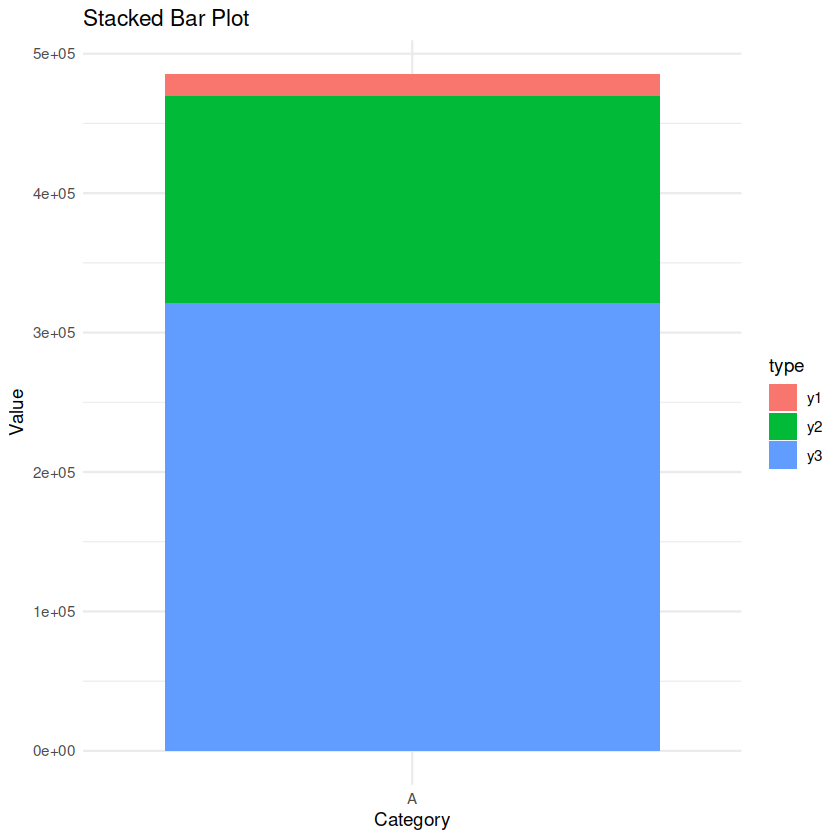

In [60]:
# Stacked bar plot for the number of peaks added at each iteration (iterative overlap merging)
data <- data.frame(
  # category = c("peaks_celltype", "peaks_bulk", "peaks_CRG-arc"),
  category = "A",
  type = c("y3", "y2", "y1"),
  value = c(length(peaks_celltype), length(non_overlapping_peaks_bulk_to_celltype), length(non_overlapping_peaks_CRG))
)

# Plot the stacked bar chart
plot <- ggplot(data, aes(x = category, y = value, fill = type)) +
          geom_bar(stat = "identity") +
          labs(title = "Stacked Bar Plot",
               x = "Category",
               y = "Value") +
          theme_minimal()
plot

path_name <- paste0(figpath, "stacked_bar_num_peaks_overlap.pdf")
ggsave(path_name, plot, device = "pdf")

## Step 2. biological replicates

- we'll assess how much overlap is present in peak_profiles between two biological replicates (compared to non-replicates)



In [ ]:
extractNonOverlappingPeaks <- function(granges1, granges2) {
  # Find overlaps
  overlaps <- findOverlaps(granges1, granges2)

  # Get unique indices(peaks) of granges1 that overlap with granges2 peaks
  unique_overlaps <- unique(queryHits(overlaps))

  # Get all indices in granges1
  all_indices_granges1 <- seq_along(granges1)

  # Find indices in granges1 that are not in unique overlaps
  unique_indices_granges1 <- setdiff(all_indices_granges1, unique_overlaps)

  # Extract non-overlapping peaks from granges1
  non_overlapping_peaks <- granges1[unique_indices_granges1]

  return(non_overlapping_peaks)
}

# Extract non-overlapping (unique) peaks in peaks_bulk that are not in peaks_celltype
non_overlapping_peaks <- extractNonOverlappingPeaks(peaks_bulk, peaks_celltype)
non_overlapping_peaks

In [61]:
# extract the peak profiles ("peaks_merged" assay)
peaks_TDR118 <- TDR118@assays$peaks_merged@ranges
peaks_TDR119 <- TDR119@assays$peaks_merged@ranges
peaks_TDR124 <- TDR124@assays$peaks_merged@ranges
peaks_TDR126 <- TDR126@assays$peaks_merged@ranges

In [75]:
# Extract non-overlapping (unique) peaks in peaks1 that are not present in peaks2

# TDR118 vs TDR119 (15-somites, biological replicates)
unique_peaks_TDR118_TDR119 <- extractNonOverlappingPeaks(peaks_TDR118, peaks_TDR119)
unique_peaks_TDR119_TDR118 <- extractNonOverlappingPeaks(peaks_TDR119, peaks_TDR118)

# TDR118 vs TDR124 (15-somites vs 30-somites)
unique_peaks_TDR118_TDR124 <- extractNonOverlappingPeaks(peaks_TDR118, peaks_TDR124)
unique_peaks_TDR124_TDR118 <- extractNonOverlappingPeaks(peaks_TDR124, peaks_TDR118)

# TDR118 vs TDR126 (15-somites vs 0-somites)
unique_peaks_TDR118_TDR126 <- extractNonOverlappingPeaks(peaks_TDR118, peaks_TDR126)
unique_peaks_TDR126_TDR118 <- extractNonOverlappingPeaks(peaks_TDR126, peaks_TDR118)

# TDR124 vs TDR126 (30-somites vs 0-somites)
unique_peaks_TDR124_TDR126 <- extractNonOverlappingPeaks(peaks_TDR124, peaks_TDR126)
unique_peaks_TDR126_TDR124 <- extractNonOverlappingPeaks(peaks_TDR126, peaks_TDR124)

In [69]:
print(length(unique_peaks_TDR119_TDR118))

[1] 67460


In [76]:
print(length(unique_peaks_TDR124_TDR126))

[1] 96326


In [77]:
# import a library for Venn Diagram 
library(VennDiagram)

Loading required package: grid


Attaching package: ‘grid’


The following object is masked from ‘package:Biostrings’:

    pattern


Loading required package: futile.logger



# Deprecated - now implemented into R scripts for data preprocessing

In [49]:
# computing the count matrices for the "peaks_merged"

multiome <- TDR118

# Change the default assay to "ATAC" for calling peaks
DefaultAssay(multiome) <- "ATAC"

# genome annotation (we need this to create a ChromatinAssay object)
genome_annotation <- Annotation(multiome)
# fragment path (path to the Fragment file)
fragpath <- Fragments(multiome)[[1]]@path


# # call peaks for the bulk population
# peaks_bulk <- CallPeaks(
#     object = multiome,
# )
# remove peaks on nonstandard chromosomes and in genomic blacklist regions
peaks_merged_all <- keepStandardChromosomes(peaks_merged_all, pruning.mode = "coarse")
# peaks <- subsetByOverlaps(x = peaks, ranges = blacklist_hg38_unified, invert = TRUE)

# quantify counts in each peak
macs2_counts_merged <- FeatureMatrix(
    fragments = Fragments(multiome),
    features = peaks_merged_all,
    cells = colnames(multiome),
    process_n=200000,
)

# create a new assay using the MACS2 peak set and add it to the Seurat object
multiome[["peaks_merged"]] <- CreateChromatinAssay(
    counts = macs2_counts_merged,
    sep = c(":", "-"),
    fragments = fragpath,
    annotation = genome_annotation,
    genome = 'GRCz11', # we will manually add the genome version
)

multiome


Extracting reads overlapping genomic regions

Computing hash



An object of class Seurat 
1565386 features across 13022 samples within 7 assays 
Active assay: ATAC (248320 features, 0 variable features)
 2 layers present: counts, data
 6 other assays present: RNA, SCT, peaks_bulk, peaks_celltype, Gene.Activity, peaks_merged
 5 dimensional reductions calculated: pca, umap.rna, lsi, umap.atac, umap.joint

In [8]:
sessionInfo()

R version 4.3.2 (2023-10-31)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Rocky Linux 8.8 (Green Obsidian)

Matrix products: default
BLAS/LAPACK: /usr/lib64/libopenblas-r0.3.15.so;  LAPACK version 3.9.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: America/Los_Angeles
tzcode source: system (glibc)

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] Matrix_1.6-3                        BSgenome.Drerio.UCSC.danRer11_1.4.2
 [3] BSgenome_1.68.0                     rtracklayer_1.60.1                 
 [5] Biostrings_2.68.1                   XVector_0.42.0               